In [1]:
print("Importing all appropriate libs")
import os,sys
import matplotlib.pyplot as plt
import numpy as np
import scipy
import cv2
import torch
import matplotlib.pyplot as plt 
import torchvision
import torchsummary
import torch.nn.functional as F
print('torch version:',torch.__version__)
print('numpy version:', np.__version__)
print("torchvision version", torchvision.__version__)

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp



#see: https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#make sure external module get reloaded
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

Importing all appropriate libs
torch version: 1.9.1+cu102
numpy version: 1.18.5
torchvision version 0.10.1+cu102


## People counting on  Mall dataset
- dset link: http://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html

In [2]:
dataset_dir = 'E:/DS PROJECTS/crowd counting 2/mall_dataset'

## Pytorch dataloader

In [3]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import skimage

import pickle, json



class MallDataset(Dataset):
    def __init__(self, meta_files, 
                 transform=None, 
                 return_gam=False, out_gam_size=None):
        with open(meta_files, 'r') as json_file:
            self.meta = json.load(json_file)
        self.meta_files = meta_files
        #to_tensor operation
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
        self.out_gam_size = out_gam_size

        if len(self.meta['images']) != len(self.meta['labels']):
            print("both images set and labels set does not have same len")
            raise ValueError("len images", len(self.meta['images']), 
                             "Not same as labels", len(self.meta['labels']))
        self.data_len = len(self.meta['images'])
        self.return_gam = return_gam

    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        '''
        Input: 
        - idx(int): index in csv file
        Return:
        - Tensor: Sepcifi data on index 
        '''
        image = Image.open(self.meta['images'][idx])
        label = self.meta['labels'][idx]
        count = len(label)
        
        
        if self.transform:
            image = self.transform(image)
           
        if self.return_gam:
            with open(self.meta['gams'][idx], 'rb') as f:
                gam = pickle.load(f)
            if self.out_gam_size:
                gam = skimage.transform.resize(gam, 
                                               self.out_gam_size, 
                                               anti_aliasing=True)
            return (idx, image, gam, count)
        
        return (idx, image, label, count)

## sanity check

In [4]:
dset = MallDataset(os.path.join(dataset_dir, 'meta.json'), 
                                   transform=transforms.Compose([
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
#                                         transforms.Normalize(mean=mean, std=std),
                                    ]))

In [5]:
idx, image, label, count = dset.__getitem__(100)

In [6]:
print('idx', idx)
print('image', image.shape)
print('label', label)
print('count', count)

idx 100
image torch.Size([3, 480, 640])
label [[136, 74], [131, 82], [176, 44], [181, 46], [187, 42], [214, 41], [227, 41], [221, 87], [232, 139], [269, 134], [278, 140], [151, 107], [104, 171], [127, 177], [145, 178], [182, 164], [223, 170], [113, 235], [74, 231], [10, 232], [131, 356], [177, 357], [240, 406], [306, 472], [352, 226], [413, 205], [483, 149], [519, 145], [540, 144], [559, 163], [508, 158]]
count 31


In [7]:
train_loader__ = torch.utils.data.DataLoader(dset,
    batch_size=10, shuffle=True,
    num_workers=0, pin_memory=True);

In [9]:
for batch_idx, (idxs, images, labels, counts) in enumerate(train_loader__):
    if (batch_idx%4) == 0:
        print('-'*10)
        print("start batch", batch_idx)
        print("len", idxs.shape)
        print(images.shape)
        print(counts.shape)
        print(idxs)

RuntimeError: each element in list of batch should be of equal size

## dataloader with GAM

In [10]:
dset = MallDataset(os.path.join(dataset_dir, 'meta.json'), 
                                   transform=transforms.Compose([
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
#                                         transforms.Normalize(mean=mean, std=std),
                                    ]), return_gam=True)

In [11]:
train_loader__gam = torch.utils.data.DataLoader(dset,
    batch_size=10, shuffle=True,
    num_workers=0, pin_memory=True);

In [19]:
for batch_idx, (idxs, images, gam, counts) in enumerate(train_loader__gam):
    print('-'*20)
    if (batch_idx%5) == 0:
        print('-'*10)
        print("start batch", batch_idx)
        print("len", idxs.shape)
        print('images', images.shape)
        print('count', counts.shape)
        print("gam", gam.shape)
        print('idxs', idxs)

--------------------
----------
start batch 0
len torch.Size([10])
images torch.Size([10, 3, 480, 640])
count torch.Size([10])
gam torch.Size([10, 480, 640])
idxs tensor([ 135,    2,   10,   83,  112,   71,   48,  140,   29,  156])
--------------------
--------------------
--------------------
--------------------
--------------------
----------
start batch 5
len torch.Size([10])
images torch.Size([10, 3, 480, 640])
count torch.Size([10])
gam torch.Size([10, 480, 640])
idxs tensor([  98,   60,   12,   22,   73,  199,  124,  137,    4,  136])
--------------------
--------------------
--------------------
--------------------
--------------------
----------
start batch 10
len torch.Size([10])
images torch.Size([10, 3, 480, 640])
count torch.Size([10])
gam torch.Size([10, 480, 640])
idxs tensor([  85,  178,  121,  169,   74,   76,   13,  179,  131,   96])
--------------------
--------------------
--------------------
--------------------
--------------------
----------
start batch 15
len 

## Visualize some example from dset

In [12]:
(idxs, input, labels, count_) = next(iter(train_loader__gam))

In [13]:
print(idxs)
print("input.shape", input.shape)
print("labels.shape", labels.shape)
print("target.shape", count_.shape)

tensor([ 146,  154,  104,  125,  119,   25,  101,  151,   26,   30])
input.shape torch.Size([10, 3, 480, 640])
labels.shape torch.Size([10, 480, 640])
target.shape torch.Size([10])


In [14]:
#get random choice indexes from batch
choice = np.random.choice(input.shape[0], size=(3,), replace=False)
choice

array([9, 0, 7])

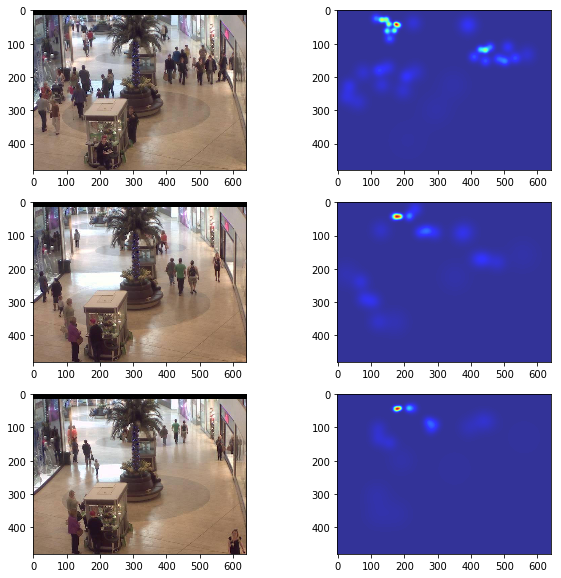

In [18]:
from matplotlib import cm
nrows, ncols = (3, 2)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
for i in range(nrows):
    axes[i,0].imshow(reverse_transform(input[choice[i]]))
#     axes[i,0].imshow(labels[choice[i]], cm.jet, alpha=0.5)
    axes[i,1].imshow(labels[choice[i]], cm.jet, alpha=0.8)
    sum_gam = labels[choice[i]].sum().item()
    groundtruth_count = count_[choice[i]].item()
    
#     axes[i,1].annotate("GAM sum: "+str(sum_gam), (5,50), color='white')
#     axes[i,1].annotate("GT count: "+str(groundtruth_count), (5,100), color='white')
#     axes[i,1].annotate("GAM sum: {0:8.2f}".format(sum_gam), (5,50), color='white')
#     axes[i,1].annotate("GT count: {0:8.2f}".format(groundtruth_count), (5,100), color='white')

## Init model

In [7]:
import torch.nn as nn
import math
class VGGRegressorGAM(nn.Module):

    def __init__(self, features, cfg=None, num_classes=1000, init_weights=True):
        super(VGGRegressorGAM, self).__init__()
        self.features = features
        self.cfg = cfg
        self.adap_pool = nn.AdaptiveAvgPool2d(1)
        self.regressor = nn.Linear(in_features=self.cfg[-2], out_features=1)
        self.density_mapper = nn.Conv2d(self.cfg[-2], 1, kernel_size=1)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        out = self.features(x)
        out = out.abs();
        count = self.adap_pool(out)
        count = count.view(count.size(0), -1);
        count = self.regressor(count)
        density_map = self.density_mapper(out).squeeze(1)
        return count, density_map # count and 

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()
                
def make_layers(cfg, batch_norm=False, in_channels=3, leaky_relu=False):
    layers = []
    in_channels = in_channels
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            relu = nn.ReLU(inplace=True)
            if leaky_relu: 
                relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
                
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), relu]
            else:
                layers += [conv2d, relu]
            in_channels = v
    return nn.Sequential(*layers)

cfg = {
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'D_modified': [64, 64, 'M', 100, 100, 'M', 164, 164, 164, 'M', 256, 256, 256, 'M', 256, 256, 256, 'M'],
    'GAS': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, ],
    'test' : [1, 1, 'M', 2, 2, 'M', 2, 2, 2, 'M', 3, 3, 3],
    'starter' : [10, 10, 'M', 20, 20, 'M', 30, 30, 30, 'M', 40, 40, 40, 'M', 40, 40, 40, 'M'],
    'GAS_customize' : [10, 10, 'M', 20, 20, 'M', 30, 30, 30, 'M', 40, 40, 40 ],
    'GAS_D_modified' : [64, 64, 'M', 100, 100, 'M', 164, 164, 164, 'M', 256, 256, 256]
}

def vgg_cfg_gam(cfg_feat):
    feature_extractor = make_layers(cfg[cfg_feat], batch_norm=False, 
                                    in_channels=3, leaky_relu=True)
    model = VGGRegressorGAM(feature_extractor, 
                            cfg=cfg[cfg_feat])
    return model

In [8]:
model = vgg_cfg_gam('GAS_customize')

In [25]:
model

VGGRegressorGAM(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.1, inplace)
    (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.1, inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace)
    (12): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace)
    (14): Conv2d(30, 30, kernel_size=(3, 3), str

In [26]:
c_, map_ = model(torch.randn(3, 3, 480, 640))

In [27]:
c_

tensor(1.00000e-03 *
       [[-3.2133],
        [-3.4211],
        [-3.3582]])

In [28]:
map_.shape

torch.Size([3, 60, 80])

## start training process

In [31]:
#Mean and std for malldset :200 images
mean=[0.53610113, 0.47058904, 0.43273771];
std=[0.2187217 , 0.21788203, 0.20973989];

train_transform = transforms.Compose([
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)
                                    ])

#since our input image is 480, 640 and we are using 
# 3 max pool layer of stride 2. coresspond to output
# image being 1/2^3 -> input.shape(480, 640) -> output.shape: (60, 80)
mall_dset_train = MallDataset(os.path.join(dataset_dir, 'meta.json'), 
                                   transform=train_transform, 
                                        return_gam=True, out_gam_size=(60, 80))

train_loader = torch.utils.data.DataLoader(mall_dset_train,
    batch_size=10, shuffle=True,
    num_workers=0, pin_memory=True);

## Start training

In [32]:
loss_hist = []

In [9]:
# Based on: 
#https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py
#https://github.com/littleaich/heatmap-regulation/blob/master/codes/vgg-cells/main_simple.py
import argparse
import os, sys
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel

import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, sampler
from torchvision import transforms

import numpy as np

class Parser:
    def __init__(self):
        self.train = 1
        self.optim = 'adam'
        self.workers = 0
        self.batch_size = 50
        self.start_epoch = 1
        self.end_epoch = 100
        self.learning_rate = 1e-3
        self.momentum = 0.9
        self.weight_decay = 1e-2
        self.save_interval = 1
        self.print_freq = 1
        self.load_epoch = 31
        self.arch  = ''
        
def get_file_handle(path_, r_w_a) :
    try :
        fhand = open(path_, r_w_a);
    except :
        print("Cannot open file {}".format(path_));
        exit();
    return fhand;

def save_pickle(path_, data) :
    fhand = get_file_handle(path_, 'wb+');
    pickle.dump(data, fhand);
    fhand.close();

def load_pickle(path_) :
    fhand = get_file_handle(path_, 'rb');
    data = pickle.load(fhand);
    fhand.close();
    return data;

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def accuracy(output, target):
    """ returns overestimate, underestimate, and total estimated difference """
    diff_ = output - target.unsqueeze(1);
    overest = diff_[diff_.ge(0)].sum();
    underest = abs(diff_[diff_.lt(0)].sum());
    return overest, underest, (overest + underest), target.sum();


def main(model, train_loader):
    torch.manual_seed(72)
    
    global args
    args = Parser()
    dataset_dir = '/work/cseos2g/datduyn/Documents/datasets/mall_dataset/'
    save_path = os.path.join('model_logs', "test_gam_gap_model")
    device = None
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(72)
        device = "cuda:0"
    else:
        device = "cpu"
    device = torch.device(device)
    
    
#     import torchsummary
#     print(torchsummary.summary(model, (3, 256, 256)))
    print(model)
    

        
        
    # check model directory
    model_dir = save_path
    log_dir = os.path.join(model_dir, 'logs')
    log_name = 'logs.csv'
    
    if not os.path.isdir(model_dir) :
        os.mkdir(model_dir);
        
    if not os.path.isdir(log_dir):
        os.mkdir(log_dir)
        
    log_handle = get_file_handle(os.path.join(log_dir, log_name), 'w+');
    log_handle.write('Epoch, LearningRate, WeightDecay,' + \
                    'Loss, LossCount, LossCam, TotalCount, Difference,' + \
                    'Overestimate, Underestimate, mae, mse\n');
    log_handle.close();
        

        
    # resume learning based on cmdline arguments
    if ((args.start_epoch > 1) and (args.train==1)) :
        load_epoch = args.start_epoch - 1;
    elif (args.train==0) and (args.load_epoch>0) :
        load_epoch = args.load_epoch;
    else :
        load_epoch = 0;

    if load_epoch > 0 :
        print("=> loading checkpoint for epoch = '{}'"
                        .format(load_epoch));
        checkpoint_name = args.arch + '_ep_' + str(load_epoch) + '.pth.tar';
        checkpoint = torch.load(os.path.join(model_dir, checkpoint_name));
        model.load_state_dict(checkpoint['state_dict']);
        
    # get dataset mean and std
    #Mean and std for malldset
    mean=[0.53610113, 0.47058904, 0.43273771];
    std=[0.2187217 , 0.21788203, 0.20973989];
    
    criterion = nn.SmoothL1Loss()#.cuda();

    if args.optim == 'adam' :
        optimizer = torch.optim.Adam(model.parameters(),
                                lr=args.learning_rate,
                                weight_decay=args.weight_decay);
    elif args.optim == 'sgd' :
        optimizer = torch.optim.SGD(model.parameters(),
                    lr=args.learning_rate,
                    momentum=args.momentum,
                    weight_decay=args.weight_decay);
        

    for epoch in range(args.start_epoch, args.end_epoch+1):
        # train for one epoch
        stats_epoch = train(train_loader, model, criterion, optimizer, epoch, device=device);
        # validate(img_dir, ann_dir, model, val_transform, epoch);

        model_name = args.arch + '_ep_' + str(epoch) + '.pth.tar';
        # get current parameters of optimizer
        for param_group in optimizer.param_groups :
            cur_lr = param_group['lr'];
            print("Curr_lr", cur_lr)
            cur_wd = param_group['weight_decay'];

        if epoch % args.save_interval == 0 :
            state = {
                'epoch': epoch,
                'arch': args.arch,
                'state_dict': model.state_dict(),
                'learning_rate': cur_lr,
                'weight_decay': cur_wd
            };

            torch.save(state, os.path.join(model_dir, model_name));

        diff_new = stats_epoch['totalest'];
        if epoch > 1:
            diff_old = load_pickle('diff_old');
            diff_change = ((diff_old - diff_new)*100.0)/diff_old;
        else :
            diff_change = 0.0;
        save_pickle('diff_old', diff_new);
        
        # write logs using logHandle
        log_handle = get_file_handle(os.path.join(log_dir, log_name), 'a');
        log_handle.write(str(epoch) + ',' +
                        str(cur_lr) + ',' +
                        # str(cur_momentum) + ',' +
                        str(cur_wd) + ',' +
                        str(stats_epoch['loss']) + ',' +
                        str(stats_epoch['loss_count']) + ',' +
                        str(stats_epoch['loss_cam']) + ',' +
                        str(stats_epoch['total_count']) + ',' +
                        str(stats_epoch['totalest']) + ',' +
                        str(stats_epoch['overest']) + ',' +
                        str(stats_epoch['underest'])+',' + 
                        str(stats_epoch['mae']) + ',' + 
                        str(stats_epoch['mse']) + ',' + '\n')

        log_handle.close();

        # ============== manually downgrade learning rate ================ #
        if epoch == 10 : # from 11
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.999;
                    
def train(train_loader, model, criterion, optimizer, epoch, device='cpu'):
    global loss_hist
#     regression_loss = criterion
#     density_map_loss = nn.
    criterion_count = nn.SmoothL1Loss()
    criterion_cam = nn.L1Loss()
    
    print('-'*30)
    print('-'*30)
    print("starting Epoch", epoch)
    global args
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_count = AverageMeter()
    losses_cam = AverageMeter()

    underest_epoch, overest_epoch, totalest_epoch, total_count = 0.0, 0.0, 0.0, 0.0;
    mae_epoch, mse_epoch = 0., 0.
    # switch to train mode
    model.train()

    
    time_start = time.time()
    n_samples = 0
    # (idxs, images, labels, counts)
    for i, (idxs, input, gam, target) in enumerate(train_loader):
        
    # for i, (input, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - time_start);

        # target = target.float().cuda(async=True);
        # input_var = torch.autograd.Variable(input).cuda();
        # target_var = torch.autograd.Variable(target);
        input_var = input.to(device)
        target = target.to(device).float()
        
        # compute output
        output_count, output_cam = model(input_var)
        output_count = output_count.view(-1)
        
        loss_count = criterion_count(output_count, target)
#         loss_count = torch.tensor([0.])
#         loss_cam = criterion_cam(output_cam, gam.float())
        loss_cam = torch.tensor([0.])
        loss = loss_count + loss_cam
        
        mse = nn.MSELoss()(output_count, target)
        mae = nn.L1Loss()(output_count, target)
        
        # loss_hist.append(loss.item())
        print("Batch idx:", i)
        print('\tPred:\n',
              output_count, 
              '\tgroundtruth\n', target)
        loss_hist.append(loss.item())
        # measure accuracy and record loss
        overest, underest, totalest, batch_count = accuracy(output_count.data, target)
        losses.update(loss.data[0], input.size(0))
        losses_count.update(loss_count.data[0], input.size(0));
        losses_cam.update(loss_cam.data[0], input.size(0));
        
        batch_target_count = target.sum().data.cpu()
        underest_epoch += underest;
        overest_epoch += overest;
        totalest_epoch += totalest;
        total_count += batch_count;
        output_batch_count = output_count.sum().data
        mae_epoch += mae
        mse_epoch += mse

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - time_start);
        time_start = time.time();
        n_samples += target.size(0)
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Loss(Count) {loss_count.val:.1f} ({loss_count.avg:.1f})  '
                  'Loss(Cam) {loss_cam.val:.3f} ({loss_cam.avg:.3f})  '
                  'Overestimate {overest:.3f} \t'
                  'Underestimate {underest:.3f} \t'
                  'TotalDifference {totalest:.3f} \t'
                  'output_batch_count {output_batch_count:.3f}\t'
                  'batch_target_count {batch_target_count}\t'
                  'mae_epoch {mae_epoch}\t'
                  'mse_epoch {mse_epoch}'.format(
                   epoch, i, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, 
                   loss_count=losses_count, loss_cam=losses_cam,
                   overest=overest/target.size(0),
                   underest=underest/target.size(0), totalest=totalest/target.size(0), 
                   output_batch_count=output_batch_count,
                   batch_target_count=batch_target_count,
                   mae_epoch=mae_epoch,
                   mse_epoch=mse_epoch));

    return {'loss':losses.avg, 'loss_count':losses_count.avg, 
            'loss_cam':losses_cam.avg,
            'overest':overest_epoch.item()/n_samples, 'underest':underest_epoch.item()/n_samples,
            'totalest':totalest_epoch.item()/n_samples, 'total_count':total_count.item(),
            'mse' : mse.item(), 'mae' : mae.item()};

In [ ]:
main(model, train_loader)

VGGRegressorGAM(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.1, inplace)
    (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.1, inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace)
    (12): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace)
    (14): Conv2d(30, 30, kernel_size=(3, 3), str

/home/cseos2g/datduyn/.conda/envs/research_env/lib/python3.6/site-packages/ipykernel_launcher.py:272: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [1][0/20]	Time 7.798 (7.798)	Data 0.384 (0.384)	Loss 6.9471 (6.9471)	Loss(Count) 6.9 (6.9)  Loss(Cam) 0.000 (0.000)  Overestimate 9.072 	Underestimate 61.831 	TotalDifference 70.904 	output_batch_count 240.241	batch_target_count 293.0	mae_epoch 7.447075843811035	mse_epoch 85.65623474121094
Batch idx: 1
	Pred:
 tensor([ 37.9023,  35.6229,  36.4980,  33.5400,  38.2885,  37.4577,
         36.2828,  34.9316,  36.0671,  36.4629]) 	groundtruth
 tensor([ 29.,  20.,  23.,  37.,  23.,  16.,  20.,  29.,  22.,  30.])
Epoch: [1][1/20]	Time 7.929 (7.863)	Data 0.525 (0.454)	Loss 11.5974 (9.2722)	Loss(Count) 11.6 (9.3)  Loss(Cam) 0.000 (0.000)  Overestimate 115.013 	Underestimate 0.959 	TotalDifference 115.973 	output_batch_count 363.054	batch_target_count 249.0	mae_epoch 19.54446029663086	mse_epoch 260.8193359375
Batch idx: 2
	Pred:
 tensor([ 32.2381,  31.1610,  32.0563,  31.0821,  32.0652,  30.5532,
         30.8538,  30.3025,  31.1615,  29.9779]) 	groundtruth
 tensor([ 29.,  23.,  26.,  23.

Epoch: [1][16/20]	Time 8.864 (8.626)	Data 0.388 (0.429)	Loss 8.7049 (5.4601)	Loss(Count) 8.7 (5.5)  Loss(Cam) 0.000 (0.000)  Overestimate 4.315 	Underestimate 84.741 	TotalDifference 89.056 	output_batch_count 196.574	batch_target_count 277.0	mae_epoch 101.00226593017578	mse_epoch 997.1670532226562
Batch idx: 17
	Pred:
 tensor([ 19.2700,  19.9829,  20.5654,  19.0792,  20.7622,  20.7866,
         19.5501,  19.7329,  20.7428,  19.3614]) 	groundtruth
 tensor([ 41.,  24.,  20.,  26.,  25.,  16.,  36.,  33.,  18.,  44.])
Epoch: [1][17/20]	Time 9.087 (8.652)	Data 0.392 (0.427)	Loss 9.4451 (5.6815)	Loss(Count) 9.4 (5.7)  Loss(Cam) 0.000 (0.000)  Overestimate 6.252 	Underestimate 89.419 	TotalDifference 95.671 	output_batch_count 199.834	batch_target_count 283.0	mae_epoch 110.93788146972656	mse_epoch 1161.0284423828125
Batch idx: 18
	Pred:
 tensor([ 19.7368,  20.5320,  21.5100,  22.0406,  20.9449,  21.4746,
         19.9493,  21.5891,  19.8949,  20.0422]) 	groundtruth
 tensor([ 41.,  22.,  16.

Batch idx: 12
	Pred:
 tensor([ 22.8373,  22.7233,  22.2673,  21.3379,  21.3475,  21.8546,
         22.4759,  21.8962,  21.2284,  21.0031]) 	groundtruth
 tensor([ 23.,  26.,  20.,  24.,  18.,  25.,  25.,  24.,  19.,  22.])
Epoch: [2][12/20]	Time 8.680 (8.886)	Data 0.389 (0.415)	Loss 1.8065 (5.1952)	Loss(Count) 1.8 (5.2)  Loss(Cam) 0.000 (0.000)  Overestimate 8.922 	Underestimate 15.950 	TotalDifference 24.872 	output_batch_count 218.972	batch_target_count 226.0	mae_epoch 73.83173370361328	mse_epoch 744.2694702148438
Batch idx: 13
	Pred:
 tensor([ 23.8493,  24.2176,  23.0035,  23.0437,  22.0116,  23.5085,
         23.8179,  21.9329,  23.6616,  24.0298]) 	groundtruth
 tensor([ 17.,  27.,  18.,  25.,  41.,  24.,  26.,  31.,  16.,  25.])
Epoch: [2][13/20]	Time 9.107 (8.902)	Data 0.391 (0.413)	Loss 5.1082 (5.1890)	Loss(Count) 5.1 (5.2)  Loss(Cam) 0.000 (0.000)  Overestimate 18.948 	Underestimate 35.871 	TotalDifference 54.819 	output_batch_count 233.076	batch_target_count 250.0	mae_epoch 79.

Epoch: [3][7/20]	Time 8.349 (8.830)	Data 0.583 (0.444)	Loss 6.7172 (6.0017)	Loss(Count) 6.7 (6.0)  Loss(Cam) 0.000 (0.000)  Overestimate 53.746 	Underestimate 14.200 	TotalDifference 67.946 	output_batch_count 270.546	batch_target_count 231.0	mae_epoch 51.75090026855469	mse_epoch 519.6056518554688
Batch idx: 8
	Pred:
 tensor([ 25.8534,  24.4884,  26.2277,  24.0579,  24.6455,  25.6135,
         24.2933,  26.1733,  26.5110,  26.2659]) 	groundtruth
 tensor([ 17.,  21.,  16.,  41.,  44.,  25.,  30.,  16.,  17.,  28.])
Epoch: [3][8/20]	Time 7.990 (8.737)	Data 0.542 (0.455)	Loss 8.1679 (6.2424)	Loss(Count) 8.2 (6.2)  Loss(Cam) 0.000 (0.000)  Overestimate 40.730 	Underestimate 41.599 	TotalDifference 82.329 	output_batch_count 254.130	batch_target_count 255.0	mae_epoch 60.411376953125	mse_epoch 628.2750854492188
Batch idx: 9
	Pred:
 tensor([ 23.7320,  23.1907,  23.4275,  23.7666,  24.5247,  23.4955,
         22.7872,  23.5600,  23.8735,  24.1936]) 	groundtruth
 tensor([ 23.,  18.,  36.,  33.,

Batch idx: 3
	Pred:
 tensor([ 19.3434,  19.4545,  19.0887,  19.4686,  20.0279,  17.8891,
         19.7819,  19.0226,  19.0595,  19.8072]) 	groundtruth
 tensor([ 20.,  26.,  22.,  20.,  27.,  41.,  24.,  25.,  23.,  16.])
Epoch: [4][3/20]	Time 8.600 (8.112)	Data 0.608 (0.447)	Loss 5.3840 (5.7052)	Loss(Count) 5.4 (5.7)  Loss(Cam) 0.000 (0.000)  Overestimate 3.300 	Underestimate 54.357 	TotalDifference 57.656 	output_batch_count 192.943	batch_target_count 244.0	mae_epoch 24.73054313659668	mse_epoch 304.3572692871094
Batch idx: 4
	Pred:
 tensor([ 20.4666,  20.2003,  19.4205,  19.5849,  19.4506,  20.8578,
         20.5545,  20.3261,  20.3421,  18.9409]) 	groundtruth
 tensor([ 23.,  20.,  41.,  44.,  21.,  33.,  21.,  19.,  25.,  31.])
Epoch: [4][4/20]	Time 8.827 (8.255)	Data 0.388 (0.435)	Loss 7.6382 (6.0918)	Loss(Count) 7.6 (6.1)  Loss(Cam) 0.000 (0.000)  Overestimate 1.295 	Underestimate 79.151 	TotalDifference 80.446 	output_batch_count 200.144	batch_target_count 278.0	mae_epoch 32.82139

Batch idx: 19
	Pred:
 tensor([ 25.7847,  26.5632,  26.8362,  25.9343,  26.0290,  26.7051,
         26.6365,  25.2910,  26.5311,  25.8159]) 	groundtruth
 tensor([ 19.,  17.,  26.,  25.,  24.,  27.,  28.,  23.,  16.,  21.])
Epoch: [4][19/20]	Time 8.993 (8.321)	Data 0.636 (0.453)	Loss 3.4708 (5.7963)	Loss(Count) 3.5 (5.8)  Loss(Cam) 0.000 (0.000)  Overestimate 38.819 	Underestimate 2.692 	TotalDifference 41.511 	output_batch_count 262.127	batch_target_count 226.0	mae_epoch 125.65393829345703	mse_epoch 1363.0931396484375
Curr_lr 0.001
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
starting Epoch 5
Batch idx: 0
	Pred:
 tensor([ 26.5691,  27.1109,  27.1847,  28.1966,  27.9517,  29.0117,
         28.1032,  27.4605,  26.8642,  25.5865]) 	groundtruth
 tensor([ 31.,  27.,  37.,  25.,  17.,  23.,  15.,  20.,  36.,  37.])
Epoch: [5][0/20]	Time 9.342 (9.342)	Dat

Epoch: [5][14/20]	Time 8.884 (8.571)	Data 0.387 (0.491)	Loss 6.3583 (5.5392)	Loss(Count) 6.4 (5.5)  Loss(Cam) 0.000 (0.000)  Overestimate 43.289 	Underestimate 20.678 	TotalDifference 63.967 	output_batch_count 263.611	batch_target_count 241.0	mae_epoch 90.31563568115234	mse_epoch 927.4715576171875
Batch idx: 15
	Pred:
 tensor([ 24.5865,  24.3209,  25.8028,  24.1464,  24.9742,  25.5375,
         24.1626,  24.3780,  25.8042,  25.8765]) 	groundtruth
 tensor([ 24.,  27.,  23.,  25.,  22.,  16.,  19.,  29.,  23.,  23.])
Epoch: [5][15/20]	Time 8.943 (8.594)	Data 0.387 (0.485)	Loss 2.9995 (5.3805)	Loss(Count) 3.0 (5.4)  Loss(Cam) 0.000 (0.000)  Overestimate 25.015 	Underestimate 6.425 	TotalDifference 31.440 	output_batch_count 249.590	batch_target_count 231.0	mae_epoch 93.80553436279297	mse_epoch 945.478515625
Batch idx: 16
	Pred:
 tensor([ 20.5340,  21.8120,  22.8249,  22.3853,  22.5911,  21.4424,
         21.7968,  21.6770,  22.1470,  23.2741]) 	groundtruth
 tensor([ 37.,  22.,  21.,  24.

Batch idx: 10
	Pred:
 tensor([ 25.1252,  25.3250,  25.1899,  26.4461,  26.7047,  27.0266,
         25.9104,  25.6736,  26.1669,  26.4639]) 	groundtruth
 tensor([ 27.,  23.,  31.,  22.,  20.,  16.,  22.,  25.,  23.,  17.])
Epoch: [6][10/20]	Time 8.993 (8.730)	Data 0.524 (0.455)	Loss 4.4455 (5.9300)	Loss(Count) 4.4 (5.9)  Loss(Cam) 0.000 (0.000)  Overestimate 40.029 	Underestimate 5.996 	TotalDifference 46.025 	output_batch_count 260.032	batch_target_count 226.0	mae_epoch 70.65399932861328	mse_epoch 734.1300659179688
Batch idx: 11
	Pred:
 tensor([ 27.1711,  27.2707,  27.7711,  28.2623,  28.1674,  28.6239,
         27.9371,  25.3527,  28.1720,  26.2894]) 	groundtruth
 tensor([ 23.,  23.,  21.,  28.,  29.,  23.,  24.,  41.,  27.,  42.])
Epoch: [6][11/20]	Time 9.180 (8.768)	Data 0.390 (0.450)	Loss 5.3685 (5.8832)	Loss(Count) 5.4 (5.9)  Loss(Cam) 0.000 (0.000)  Overestimate 24.369 	Underestimate 30.351 	TotalDifference 54.720 	output_batch_count 275.018	batch_target_count 281.0	mae_epoch 76.

Epoch: [7][5/20]	Time 9.264 (9.056)	Data 0.521 (0.509)	Loss 4.8186 (5.7969)	Loss(Count) 4.8 (5.8)  Loss(Cam) 0.000 (0.000)  Overestimate 11.883 	Underestimate 37.490 	TotalDifference 49.373 	output_batch_count 264.393	batch_target_count 290.0	mae_epoch 37.65504455566406	mse_epoch 358.6409606933594
Batch idx: 6
	Pred:
 tensor([ 25.9755,  24.3636,  24.5686,  24.6995,  25.1690,  26.2738,
         26.0912,  26.4792,  26.8024,  23.9084]) 	groundtruth
 tensor([ 22.,  37.,  30.,  38.,  25.,  23.,  24.,  19.,  26.,  37.])
Epoch: [7][6/20]	Time 9.011 (9.049)	Data 0.385 (0.491)	Loss 5.7616 (5.7918)	Loss(Count) 5.8 (5.8)  Loss(Cam) 0.000 (0.000)  Overestimate 14.585 	Underestimate 41.254 	TotalDifference 55.840 	output_batch_count 254.331	batch_target_count 281.0	mae_epoch 43.88014602661133	mse_epoch 421.13885498046875
Batch idx: 7
	Pred:
 tensor([ 25.5406,  25.3299,  24.3234,  24.3418,  24.0149,  22.6954,
         24.8699,  25.3470,  24.5946,  25.4792]) 	groundtruth
 tensor([ 26.,  18.,  20.,  2

Batch idx: 1
	Pred:
 tensor([ 23.2593,  23.8230,  25.0711,  24.4740,  23.4173,  23.5318,
         24.1159,  24.7609,  24.4457,  22.4609]) 	groundtruth
 tensor([ 29.,  27.,  29.,  19.,  41.,  23.,  29.,  23.,  16.,  41.])
Epoch: [8][1/20]	Time 8.633 (8.731)	Data 0.389 (0.405)	Loss 6.5174 (5.9246)	Loss(Count) 6.5 (5.9)  Loss(Cam) 0.000 (0.000)  Overestimate 14.852 	Underestimate 52.492 	TotalDifference 67.344 	output_batch_count 239.360	batch_target_count 277.0	mae_epoch 12.82441520690918	mse_epoch 143.67022705078125
Batch idx: 2
	Pred:
 tensor([ 25.0757,  26.3902,  25.1680,  24.6521,  26.0864,  24.7774,
         26.0264,  25.6660,  25.0768,  25.6802]) 	groundtruth
 tensor([ 13.,  25.,  20.,  37.,  24.,  25.,  27.,  31.,  23.,  24.])
Epoch: [8][2/20]	Time 8.813 (8.758)	Data 0.427 (0.413)	Loss 3.8658 (5.2383)	Loss(Count) 3.9 (5.2)  Loss(Cam) 0.000 (0.000)  Overestimate 24.334 	Underestimate 18.734 	TotalDifference 43.068 	output_batch_count 254.599	batch_target_count 249.0	mae_epoch 17.15

Batch idx: 17
	Pred:
 tensor([ 19.4602,  19.7712,  20.0180,  20.3634,  19.8651,  19.9152,
         19.9149,  20.8611,  19.5920,  19.8371]) 	groundtruth
 tensor([ 28.,  25.,  23.,  20.,  22.,  30.,  33.,  32.,  24.,  27.])
Epoch: [8][17/20]	Time 9.238 (8.564)	Data 0.541 (0.432)	Loss 6.0331 (5.3854)	Loss(Count) 6.0 (5.4)  Loss(Cam) 0.000 (0.000)  Overestimate 0.124 	Underestimate 64.526 	TotalDifference 64.650 	output_batch_count 199.598	batch_target_count 264.0	mae_epoch 105.6204833984375	mse_epoch 1047.885009765625
Batch idx: 18
	Pred:
 tensor([ 20.4865,  20.6350,  21.1259,  21.5462,  20.9628,  20.3761,
         20.0728,  19.8436,  20.5016,  21.5258]) 	groundtruth
 tensor([ 23.,  29.,  17.,  15.,  25.,  24.,  42.,  37.,  25.,  28.])
Epoch: [8][18/20]	Time 9.131 (8.593)	Data 0.603 (0.441)	Loss 7.4268 (5.4929)	Loss(Count) 7.4 (5.5)  Loss(Cam) 0.000 (0.000)  Overestimate 9.415 	Underestimate 67.339 	TotalDifference 76.754 	output_batch_count 207.077	batch_target_count 265.0	mae_epoch 113.

Epoch: [9][12/20]	Time 8.438 (8.348)	Data 0.388 (0.439)	Loss 7.6485 (5.6074)	Loss(Count) 7.6 (5.6)  Loss(Cam) 0.000 (0.000)  Overestimate 48.313 	Underestimate 29.216 	TotalDifference 77.528 	output_batch_count 296.097	batch_target_count 277.0	mae_epoch 79.0625991821289	mse_epoch 776.9862060546875
Batch idx: 13
	Pred:
 tensor([ 33.8365,  32.9857,  33.5861,  33.8078,  32.9848,  32.2841,
         32.2898,  33.0845,  32.1764,  31.8213]) 	groundtruth
 tensor([ 22.,  17.,  20.,  25.,  20.,  31.,  33.,  23.,  25.,  24.])
Epoch: [9][13/20]	Time 9.041 (8.397)	Data 0.387 (0.435)	Loss 8.5319 (5.8163)	Loss(Count) 8.5 (5.8)  Loss(Cam) 0.000 (0.000)  Overestimate 89.203 	Underestimate 0.346 	TotalDifference 89.549 	output_batch_count 328.857	batch_target_count 240.0	mae_epoch 88.09033966064453	mse_epoch 881.2796630859375
Batch idx: 14
	Pred:
 tensor([ 32.5951,  32.0046,  31.1460,  33.4979,  31.0061,  31.1582,
         32.2417,  32.7502,  31.8010,  32.2524]) 	groundtruth
 tensor([ 23.,  26.,  21.,  

Batch idx: 8
	Pred:
 tensor([ 26.7259,  26.6708,  25.0368,  27.4363,  25.6454,  26.5637,
         26.2489,  27.2797,  27.3955,  27.2803]) 	groundtruth
 tensor([ 18.,  20.,  37.,  25.,  22.,  17.,  24.,  15.,  29.,  16.])
Epoch: [10][8/20]	Time 8.492 (8.676)	Data 0.452 (0.444)	Loss 6.5419 (6.3490)	Loss(Count) 6.5 (6.3)  Loss(Cam) 0.000 (0.000)  Overestimate 56.027 	Underestimate 12.743 	TotalDifference 68.770 	output_batch_count 266.283	batch_target_count 223.0	mae_epoch 61.551719665527344	mse_epoch 637.3489990234375
Batch idx: 9
	Pred:
 tensor([ 24.8028,  24.7425,  24.4661,  24.1285,  23.2959,  23.6048,
         24.3517,  23.6845,  24.7365,  23.9324]) 	groundtruth
 tensor([ 15.,  28.,  25.,  19.,  35.,  20.,  25.,  27.,  16.,  24.])
Epoch: [10][9/20]	Time 8.883 (8.697)	Data 0.547 (0.454)	Loss 4.2405 (6.1382)	Loss(Count) 4.2 (6.1)  Loss(Cam) 0.000 (0.000)  Overestimate 27.021 	Underestimate 19.275 	TotalDifference 46.296 	output_batch_count 241.746	batch_target_count 234.0	mae_epoch 66.

Epoch: [11][3/20]	Time 9.204 (8.764)	Data 0.486 (0.412)	Loss 5.5912 (5.0200)	Loss(Count) 5.6 (5.0)  Loss(Cam) 0.000 (0.000)  Overestimate 40.774 	Underestimate 18.811 	TotalDifference 59.585 	output_batch_count 273.963	batch_target_count 252.0	mae_epoch 21.93231773376465	mse_epoch 200.71319580078125
Batch idx: 4
	Pred:
 tensor([ 27.3589,  25.7684,  26.7206,  26.8931,  25.7222,  27.1076,
         26.0886,  26.1776,  26.3551,  26.9014]) 	groundtruth
 tensor([ 23.,  31.,  23.,  16.,  18.,  16.,  20.,  30.,  26.,  26.])
Epoch: [11][4/20]	Time 8.609 (8.733)	Data 0.531 (0.435)	Loss 4.9414 (5.0043)	Loss(Count) 4.9 (5.0)  Loss(Cam) 0.000 (0.000)  Overestimate 44.177 	Underestimate 8.083 	TotalDifference 52.260 	output_batch_count 265.093	batch_target_count 229.0	mae_epoch 27.352458953857422	mse_epoch 242.16339111328125
Batch idx: 5
	Pred:
 tensor([ 24.3405,  24.3547,  24.5003,  24.4926,  24.8097,  23.3572,
         24.7992,  24.1004,  23.9389,  24.3289]) 	groundtruth
 tensor([ 23.,  21.,  23.,

Epoch: [11][19/20]	Time 8.866 (8.682)	Data 0.550 (0.455)	Loss 5.0939 (5.6309)	Loss(Count) 5.1 (5.6)  Loss(Cam) 0.000 (0.000)  Overestimate 11.560 	Underestimate 44.028 	TotalDifference 55.587 	output_batch_count 208.532	batch_target_count 241.0	mae_epoch 122.22586822509766	mse_epoch 1234.6435546875
Curr_lr 0.000999
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
------------------------------
starting Epoch 12
Batch idx: 0
	Pred:
 tensor([ 20.9358,  20.1245,  19.9285,  20.3144,  19.5480,  19.3777,
         19.2533,  20.3205,  20.3406,  20.3436]) 	groundtruth
 tensor([ 26.,  21.,  17.,  23.,  37.,  27.,  29.,  22.,  16.,  17.])
Epoch: [12][0/20]	Time 9.125 (9.125)	Data 0.397 (0.397)	Loss 5.0746 (5.0746)	Loss(Count) 5.1 (5.1)  Loss(Cam) 0.000 (0.000)  Overestimate 10.146 	Underestimate 44.659 	TotalDifference 54.805 	output_batch_count 200.487	batch_target_count 235.0	mae_epoch 5.57

Batch idx: 15
	Pred:
 tensor([ 22.2818,  23.7348,  23.5573,  23.8782,  23.2255,  23.3493,
         22.1870,  22.8819,  22.7560,  23.9136]) 	groundtruth
 tensor([ 30.,  19.,  20.,  25.,  23.,  24.,  40.,  29.,  23.,  18.])
Epoch: [12][15/20]	Time 7.566 (8.666)	Data 0.486 (0.484)	Loss 4.3744 (5.6726)	Loss(Count) 4.4 (5.7)  Loss(Cam) 0.000 (0.000)  Overestimate 13.261 	Underestimate 32.496 	TotalDifference 45.757 	output_batch_count 231.765	batch_target_count 251.0	mae_epoch 98.51081848144531	mse_epoch 1023.9540405273438
Batch idx: 16
	Pred:
 tensor([ 24.7917,  23.8103,  23.5728,  23.8887,  25.1077,  24.3722,
         24.6476,  24.0125,  23.7842,  25.0948]) 	groundtruth
 tensor([ 21.,  36.,  21.,  22.,  32.,  15.,  21.,  33.,  37.,  18.])
Epoch: [12][16/20]	Time 8.596 (8.662)	Data 0.509 (0.486)	Loss 6.4653 (5.7192)	Loss(Count) 6.5 (5.7)  Loss(Cam) 0.000 (0.000)  Overestimate 27.849 	Underestimate 40.767 	TotalDifference 68.616 	output_batch_count 243.082	batch_target_count 256.0	mae_epoch

Epoch: [13][10/20]	Time 9.153 (8.553)	Data 0.531 (0.494)	Loss 7.6943 (6.0600)	Loss(Count) 7.7 (6.1)  Loss(Cam) 0.000 (0.000)  Overestimate 37.888 	Underestimate 39.741 	TotalDifference 77.629 	output_batch_count 273.146	batch_target_count 275.0	mae_epoch 71.92659759521484	mse_epoch 781.4719848632812
Batch idx: 11
	Pred:
 tensor([ 29.7408,  28.9519,  30.2013,  29.7584,  29.2065,  27.3299,
         29.8246,  29.6242,  29.4451,  29.3849]) 	groundtruth
 tensor([ 26.,  25.,  23.,  19.,  23.,  41.,  27.,  19.,  21.,  16.])
Epoch: [13][11/20]	Time 8.603 (8.557)	Data 0.389 (0.485)	Loss 7.5808 (6.1868)	Loss(Count) 7.6 (6.2)  Loss(Cam) 0.000 (0.000)  Overestimate 65.121 	Underestimate 11.653 	TotalDifference 76.774 	output_batch_count 293.468	batch_target_count 240.0	mae_epoch 80.00737762451172	mse_epoch 860.8651733398438
Batch idx: 12
	Pred:
 tensor([ 28.5395,  27.8899,  27.9246,  27.8248,  29.0695,  27.4333,
         27.2190,  28.2246,  27.6964,  28.6132]) 	groundtruth
 tensor([ 27.,  23.,  27

Batch idx: 6
	Pred:
 tensor([ 28.1613,  29.2125,  27.2798,  28.7522,  29.4539,  27.0419,
         27.8800,  29.7664,  28.5476,  28.9361]) 	groundtruth
 tensor([ 22.,  20.,  31.,  24.,  21.,  37.,  38.,  28.,  33.,  24.])
Epoch: [14][6/20]	Time 8.902 (8.874)	Data 0.527 (0.507)	Loss 5.8533 (6.2967)	Loss(Count) 5.9 (6.3)  Loss(Cam) 0.000 (0.000)  Overestimate 32.199 	Underestimate 25.167 	TotalDifference 57.366 	output_batch_count 285.032	batch_target_count 278.0	mae_epoch 47.48491668701172	mse_epoch 469.9029541015625
Batch idx: 7
	Pred:
 tensor([ 28.3189,  29.2421,  29.1140,  28.3723,  27.5697,  29.1743,
         27.9091,  27.6507,  29.0067,  28.3060]) 	groundtruth
 tensor([ 23.,  24.,  19.,  23.,  36.,  32.,  31.,  37.,  29.,  23.])
Epoch: [14][7/20]	Time 8.813 (8.866)	Data 0.566 (0.515)	Loss 5.0550 (6.1415)	Loss(Count) 5.1 (6.1)  Loss(Cam) 0.000 (0.000)  Overestimate 30.386 	Underestimate 22.722 	TotalDifference 53.107 	output_batch_count 284.664	batch_target_count 277.0	mae_epoch 52.9

Epoch: [15][1/20]	Time 8.568 (8.457)	Data 0.390 (0.388)	Loss 7.0060 (7.6443)	Loss(Count) 7.0 (7.6)  Loss(Cam) 0.000 (0.000)  Overestimate 42.094 	Underestimate 28.732 	TotalDifference 70.826 	output_batch_count 264.362	batch_target_count 251.0	mae_epoch 16.239805221557617	mse_epoch 188.5076141357422
Batch idx: 2
	Pred:
 tensor([ 25.5303,  26.3769,  26.3413,  26.0900,  25.1930,  26.1081,
         27.1118,  26.3494,  26.5521,  25.5470]) 	groundtruth
 tensor([ 44.,  19.,  16.,  26.,  29.,  24.,  26.,  23.,  19.,  23.])
Epoch: [15][2/20]	Time 9.128 (8.680)	Data 0.384 (0.387)	Loss 5.2167 (6.8351)	Loss(Count) 5.2 (6.8)  Loss(Cam) 0.000 (0.000)  Overestimate 33.306 	Underestimate 21.106 	TotalDifference 54.412 	output_batch_count 261.200	batch_target_count 249.0	mae_epoch 21.915145874023438	mse_epoch 248.24905395507812
Batch idx: 3
	Pred:
 tensor([ 24.8350,  25.9382,  24.7403,  23.2496,  24.5257,  25.4460,
         24.3733,  24.9609,  26.3168,  25.9333]) 	groundtruth
 tensor([ 37.,  15.,  22.

Epoch: [15][17/20]	Time 8.343 (8.592)	Data 0.392 (0.448)	Loss 7.7260 (5.7455)	Loss(Count) 7.7 (5.7)  Loss(Cam) 0.000 (0.000)  Overestimate 49.706 	Underestimate 28.202 	TotalDifference 77.908 	output_batch_count 279.504	batch_target_count 258.0	mae_epoch 112.06947326660156	mse_epoch 1098.3577880859375
Batch idx: 18
	Pred:
 tensor([ 26.5561,  25.3256,  26.3796,  25.7424,  25.9158,  25.1635,
         25.2530,  24.7831,  25.7260,  26.1684]) 	groundtruth
 tensor([ 22.,  27.,  28.,  15.,  26.,  37.,  25.,  30.,  26.,  33.])
Epoch: [15][18/20]	Time 7.892 (8.555)	Data 0.387 (0.444)	Loss 3.9051 (5.6486)	Loss(Count) 3.9 (5.6)  Loss(Cam) 0.000 (0.000)  Overestimate 15.347 	Underestimate 27.333 	TotalDifference 42.680 	output_batch_count 257.014	batch_target_count 269.0	mae_epoch 116.37841796875	mse_epoch 1133.929931640625
Batch idx: 19
	Pred:
 tensor([ 24.6357,  24.5803,  25.3065,  25.2246,  24.5188,  24.0548,
         24.7187,  24.0927,  25.2053,  25.2400]) 	groundtruth
 tensor([ 16.,  17.,  31

Batch idx: 13
	Pred:
 tensor([ 21.5973,  22.9980,  22.3636,  21.3670,  22.3614,  22.6761,
         22.7338,  22.8610,  22.7518,  22.9924]) 	groundtruth
 tensor([ 36.,  23.,  17.,  41.,  23.,  20.,  19.,  16.,  17.,  23.])
Epoch: [16][13/20]	Time 8.650 (8.574)	Data 0.547 (0.447)	Loss 5.5126 (5.3832)	Loss(Count) 5.5 (5.4)  Loss(Cam) 0.000 (0.000)  Overestimate 23.351 	Underestimate 33.649 	TotalDifference 57.000 	output_batch_count 224.703	batch_target_count 235.0	mae_epoch 81.95146179199219	mse_epoch 843.8912353515625
Batch idx: 14
	Pred:
 tensor([ 22.7525,  22.6856,  23.1611,  21.7987,  23.2255,  22.8211,
         21.6031,  23.2787,  22.7670,  23.0766]) 	groundtruth
 tensor([ 23.,  26.,  15.,  29.,  22.,  24.,  29.,  29.,  17.,  28.])
Epoch: [16][14/20]	Time 8.613 (8.577)	Data 0.492 (0.450)	Loss 4.0420 (5.2938)	Loss(Count) 4.0 (5.3)  Loss(Cam) 0.000 (0.000)  Overestimate 14.285 	Underestimate 29.115 	TotalDifference 43.400 	output_batch_count 227.170	batch_target_count 242.0	mae_epoch 

Epoch: [17][8/20]	Time 8.766 (8.481)	Data 0.492 (0.474)	Loss 5.4146 (4.9259)	Loss(Count) 5.4 (4.9)  Loss(Cam) 0.000 (0.000)  Overestimate 46.117 	Underestimate 12.484 	TotalDifference 58.601 	output_batch_count 237.633	batch_target_count 204.0	mae_epoch 48.52970504760742	mse_epoch 439.73162841796875
Batch idx: 9
	Pred:
 tensor([ 21.5933,  22.0331,  21.2633,  22.6144,  21.9522,  20.7837,
         21.9557,  22.1094,  21.7569,  22.1390]) 	groundtruth
 tensor([ 18.,  27.,  31.,  26.,  26.,  31.,  23.,  26.,  23.,  17.])
Epoch: [17][9/20]	Time 7.516 (8.384)	Data 0.464 (0.473)	Loss 4.2264 (4.8559)	Loss(Count) 4.2 (4.9)  Loss(Cam) 0.000 (0.000)  Overestimate 8.640 	Underestimate 38.439 	TotalDifference 47.079 	output_batch_count 218.201	batch_target_count 248.0	mae_epoch 53.25606155395508	mse_epoch 470.61029052734375
Batch idx: 10
	Pred:
 tensor([ 22.1205,  20.7099,  20.7477,  20.9873,  21.7441,  21.5393,
         20.4650,  21.1946,  21.2098,  21.7543]) 	groundtruth
 tensor([ 28.,  40.,  29.,

Batch idx: 4
	Pred:
 tensor([ 19.1165,  19.4945,  18.4796,  19.0987,  19.1181,  18.6487,
         18.9718,  18.4632,  18.6168,  18.6954]) 	groundtruth
 tensor([ 18.,  20.,  22.,  16.,  19.,  25.,  25.,  25.,  16.,  30.])
Epoch: [18][4/20]	Time 9.237 (8.800)	Data 0.386 (0.470)	Loss 3.6708 (4.8282)	Loss(Count) 3.7 (4.8)  Loss(Cam) 0.000 (0.000)  Overestimate 6.694 	Underestimate 33.991 	TotalDifference 40.684 	output_batch_count 188.703	batch_target_count 216.0	mae_epoch 26.475189208984375	mse_epoch 241.99542236328125
Batch idx: 5
	Pred:
 tensor([ 17.8730,  18.3615,  18.6630,  18.6095,  17.9896,  18.8928,
         19.0466,  18.5175,  18.7814,  18.9761]) 	groundtruth
 tensor([ 29.,  27.,  27.,  25.,  38.,  20.,  33.,  24.,  17.,  16.])
Epoch: [18][5/20]	Time 9.234 (8.873)	Data 0.490 (0.473)	Loss 7.4804 (5.2703)	Loss(Count) 7.5 (5.3)  Loss(Cam) 0.000 (0.000)  Overestimate 4.142 	Underestimate 74.431 	TotalDifference 78.573 	output_batch_count 185.711	batch_target_count 256.0	mae_epoch 34.4

Batch idx: 0
	Pred:
 tensor([ 21.5700,  21.7297,  22.5273,  22.8548,  21.9096,  22.5602,
         22.3672,  22.2056,  22.5500,  21.3205]) 	groundtruth
 tensor([ 33.,  37.,  20.,  22.,  33.,  24.,  22.,  30.,  33.,  29.])
Epoch: [19][0/20]	Time 7.701 (7.701)	Data 0.386 (0.386)	Loss 6.4115 (6.4115)	Loss(Count) 6.4 (6.4)  Loss(Cam) 0.000 (0.000)  Overestimate 2.773 	Underestimate 64.178 	TotalDifference 66.950 	output_batch_count 221.595	batch_target_count 283.0	mae_epoch 6.890376091003418	mse_epoch 72.50810241699219
Batch idx: 1
	Pred:
 tensor([ 24.6712,  23.9865,  24.8709,  24.6895,  23.3799,  24.6508,
         24.2411,  24.1646,  24.1551,  24.1605]) 	groundtruth
 tensor([ 17.,  15.,  26.,  26.,  25.,  18.,  17.,  17.,  24.,  16.])
Epoch: [19][1/20]	Time 8.729 (8.215)	Data 0.385 (0.385)	Loss 4.5446 (5.4780)	Loss(Count) 4.5 (5.5)  Loss(Cam) 0.000 (0.000)  Overestimate 46.142 	Underestimate 4.172 	TotalDifference 50.315 	output_batch_count 242.970	batch_target_count 201.0	mae_epoch 11.899

Batch idx: 16
	Pred:
 tensor([ 20.2798,  22.2230,  21.4047,  22.0048,  21.0811,  21.4093,
         20.9966,  21.6985,  20.9797,  20.0061]) 	groundtruth
 tensor([ 37.,  25.,  24.,  29.,  35.,  29.,  40.,  14.,  23.,  37.])
Epoch: [19][16/20]	Time 8.684 (8.743)	Data 0.500 (0.435)	Loss 9.1313 (5.1221)	Loss(Count) 9.1 (5.1)  Loss(Cam) 0.000 (0.000)  Overestimate 7.208 	Underestimate 88.125 	TotalDifference 95.333 	output_batch_count 212.084	batch_target_count 293.0	mae_epoch 94.92569732666016	mse_epoch 942.87939453125
Batch idx: 17
	Pred:
 tensor([ 23.3792,  22.4848,  23.8827,  23.5878,  23.3915,  22.6712,
         22.4236,  22.6132,  22.4565,  23.1707]) 	groundtruth
 tensor([ 20.,  26.,  16.,  24.,  19.,  37.,  29.,  29.,  30.,  23.])
Epoch: [19][17/20]	Time 9.011 (8.758)	Data 0.384 (0.432)	Loss 5.0104 (5.1159)	Loss(Count) 5.0 (5.1)  Loss(Cam) 0.000 (0.000)  Overestimate 14.260 	Underestimate 37.198 	TotalDifference 51.458 	output_batch_count 230.061	batch_target_count 253.0	mae_epoch 100

Epoch: [20][11/20]	Time 9.222 (8.760)	Data 0.388 (0.416)	Loss 3.8114 (5.1857)	Loss(Count) 3.8 (5.2)  Loss(Cam) 0.000 (0.000)  Overestimate 11.321 	Underestimate 30.850 	TotalDifference 42.171 	output_batch_count 244.470	batch_target_count 264.0	mae_epoch 67.9925308227539	mse_epoch 651.2978515625
Batch idx: 12
	Pred:
 tensor([ 24.8228,  23.4005,  23.7240,  25.0127,  24.5351,  24.5669,
         23.3507,  24.9523,  23.8489,  24.3722]) 	groundtruth
 tensor([ 17.,  29.,  25.,  29.,  25.,  20.,  41.,  25.,  36.,  16.])
Epoch: [20][12/20]	Time 8.000 (8.702)	Data 0.500 (0.422)	Loss 5.7534 (5.2294)	Loss(Count) 5.8 (5.2)  Loss(Cam) 0.000 (0.000)  Overestimate 19.780 	Underestimate 40.193 	TotalDifference 59.973 	output_batch_count 242.586	batch_target_count 263.0	mae_epoch 74.1863021850586	mse_epoch 717.3370971679688
Batch idx: 13
	Pred:
 tensor([ 25.3248,  25.0068,  25.0796,  24.3313,  25.1773,  25.0721,
         24.6807,  24.9662,  23.7447,  24.0906]) 	groundtruth
 tensor([ 19.,  24.,  16.,  3

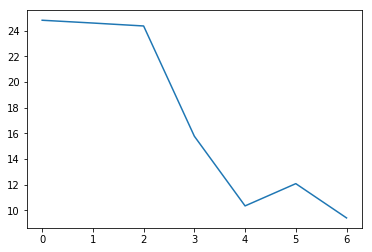

In [36]:
plt.plot(loss_hist)

## Evaluate model

In [10]:
# model = vgg_cfg_gam('GAS_D_modified')
# #since trained on gpu. therefore need to convert weight to cpu
# model_meta = torch.load('model_logs/05_12_19_d_modified_starter/_ep_22.pth.tar', map_location=lambda storage, loc: storage)

model_dir = 'model_logs/test_gam_gap_model/'
model = vgg_cfg_gam('GAS_customize')
model_meta = torch.load('model_logs/test_gam_gap_model/_ep_7.pth.tar')

In [11]:
model.load_state_dict(model_meta['state_dict'])
model.eval()

VGGRegressorGAM(
  (features): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace)
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.1, inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.1, inplace)
    (7): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.1, inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1, inplace)
    (12): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): LeakyReLU(negative_slope=0.1, inplace)
    (14): Conv2d(30, 30, kernel_size=(3, 3), str

## Test dataloader

In [12]:
# mall_dset_train = MallDataset(os.path.join(dataset_dir, 'meta.json'), 
#                                    transform=train_transform, 
#                                     return_gam=True, out_gam_size=(60, 80))

In [13]:
mean=[0.53610113, 0.47058904, 0.43273771];
std=[0.2187217 , 0.21788203, 0.20973989];
test_transform = transforms.Compose([
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.RandomVerticalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std)
                                    ])

#since our input image is 480, 640 and we are using 
# 3 max pool layer of stride 2. coresspond to output
# image being 1/2^3 -> input.shape(480, 640) -> output.shape: (60, 80)
mall_dset_test = MallDataset(os.path.join(dataset_dir, 'meta_test.json'), 
                                   transform=test_transform, 
                                    return_gam=True, out_gam_size=(60, 80))

mall_dset = MallDataset(os.path.join(dataset_dir, 'meta_test.json'), 
                                   transform=None, 
                                    return_gam=True, out_gam_size=(480, 640))

test_loader = torch.utils.data.DataLoader(mall_dset_test,
    batch_size=4, shuffle=True,
    num_workers=0, pin_memory=True);


In [35]:
(idxs_test, input_test, labels_test, target_test) = next(iter(test_loader))

/home/cseos2g/datduyn/.conda/envs/research_env/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [25]:
output_count_test, output_map_test = model(input_test)

In [26]:
del model

In [27]:
print('output_count_test', output_count_test.shape)
print('output_map_test',output_map_test.shape)

output_count_test torch.Size([4, 1])
output_map_test torch.Size([4, 60, 80])


In [28]:
print('output_count_test', output_count_test)
print("Ground truth output", target_test)

output_count_test tensor([[ 24.0596],
        [ 23.6823],
        [ 28.6106],
        [ 20.6804]])
Ground truth output tensor([ 42,  31,  33,  44])


In [29]:
output_map_resize = skimage.transform.resize(output_map_test[0].detach().numpy(), 
                               (480, 640), 
                               anti_aliasing=True)

In [30]:
#get original image
idx, original_image, label__, count__ = mall_dset.__getitem__(idxs_test[0])

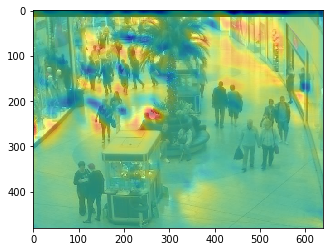

In [31]:
from matplotlib import cm
plt.imshow(original_image)
plt.imshow(output_map_resize, cm.jet, alpha=0.5)

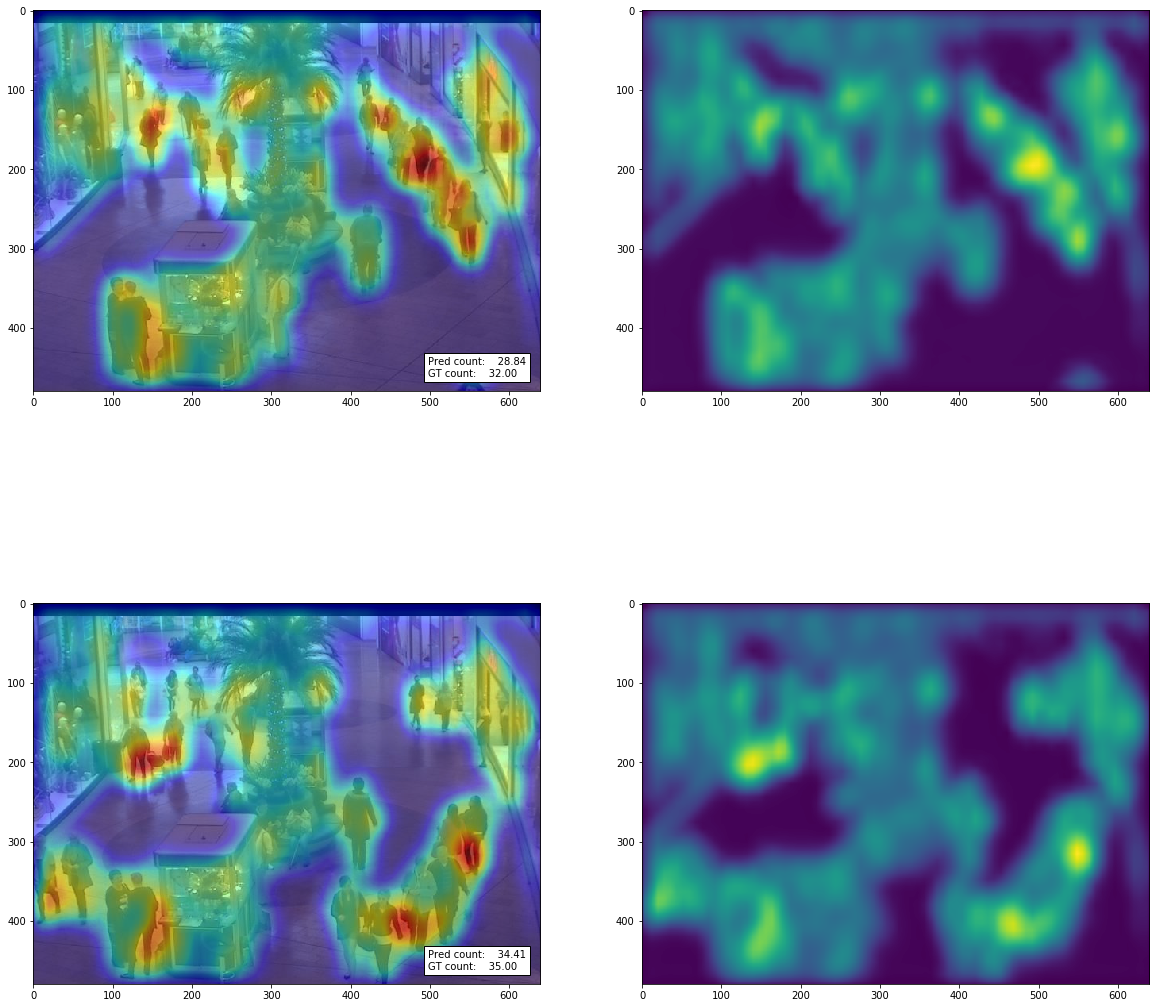

In [62]:
from matplotlib import cm
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
nrows, ncols = (2, 2)

#get random choice indexes from batch
choice = np.random.choice(input_test.shape[0], size=(2,), replace=False)
choice

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows):
    idx, original_image, label__, count__ = mall_dset.__getitem__(idxs_test[choice[i]])
    output_map_resize = skimage.transform.resize(output_map_test[choice[i]].detach().numpy(), 
                               (480, 640), 
                               anti_aliasing=True)
    offsetbox = TextArea("Pred count: {0:8.2f}".format(output_count_test[choice[i]].item()) + 
                         "\nGT count: {0:8.2f}".format(float(count__)),
                         minimumdescent=False)
    ab = AnnotationBbox(offsetbox, (560,450), #(x, y)
                        xybox=(0, 0),
                        xycoords='data',
                        boxcoords="offset points")
    
    axes[i,0].imshow(original_image)
    axes[i,0].imshow(output_map_resize, cm.jet, alpha=0.5)
    axes[i,0].add_artist(ab)
    
    axes[i,1].imshow(output_map_resize)

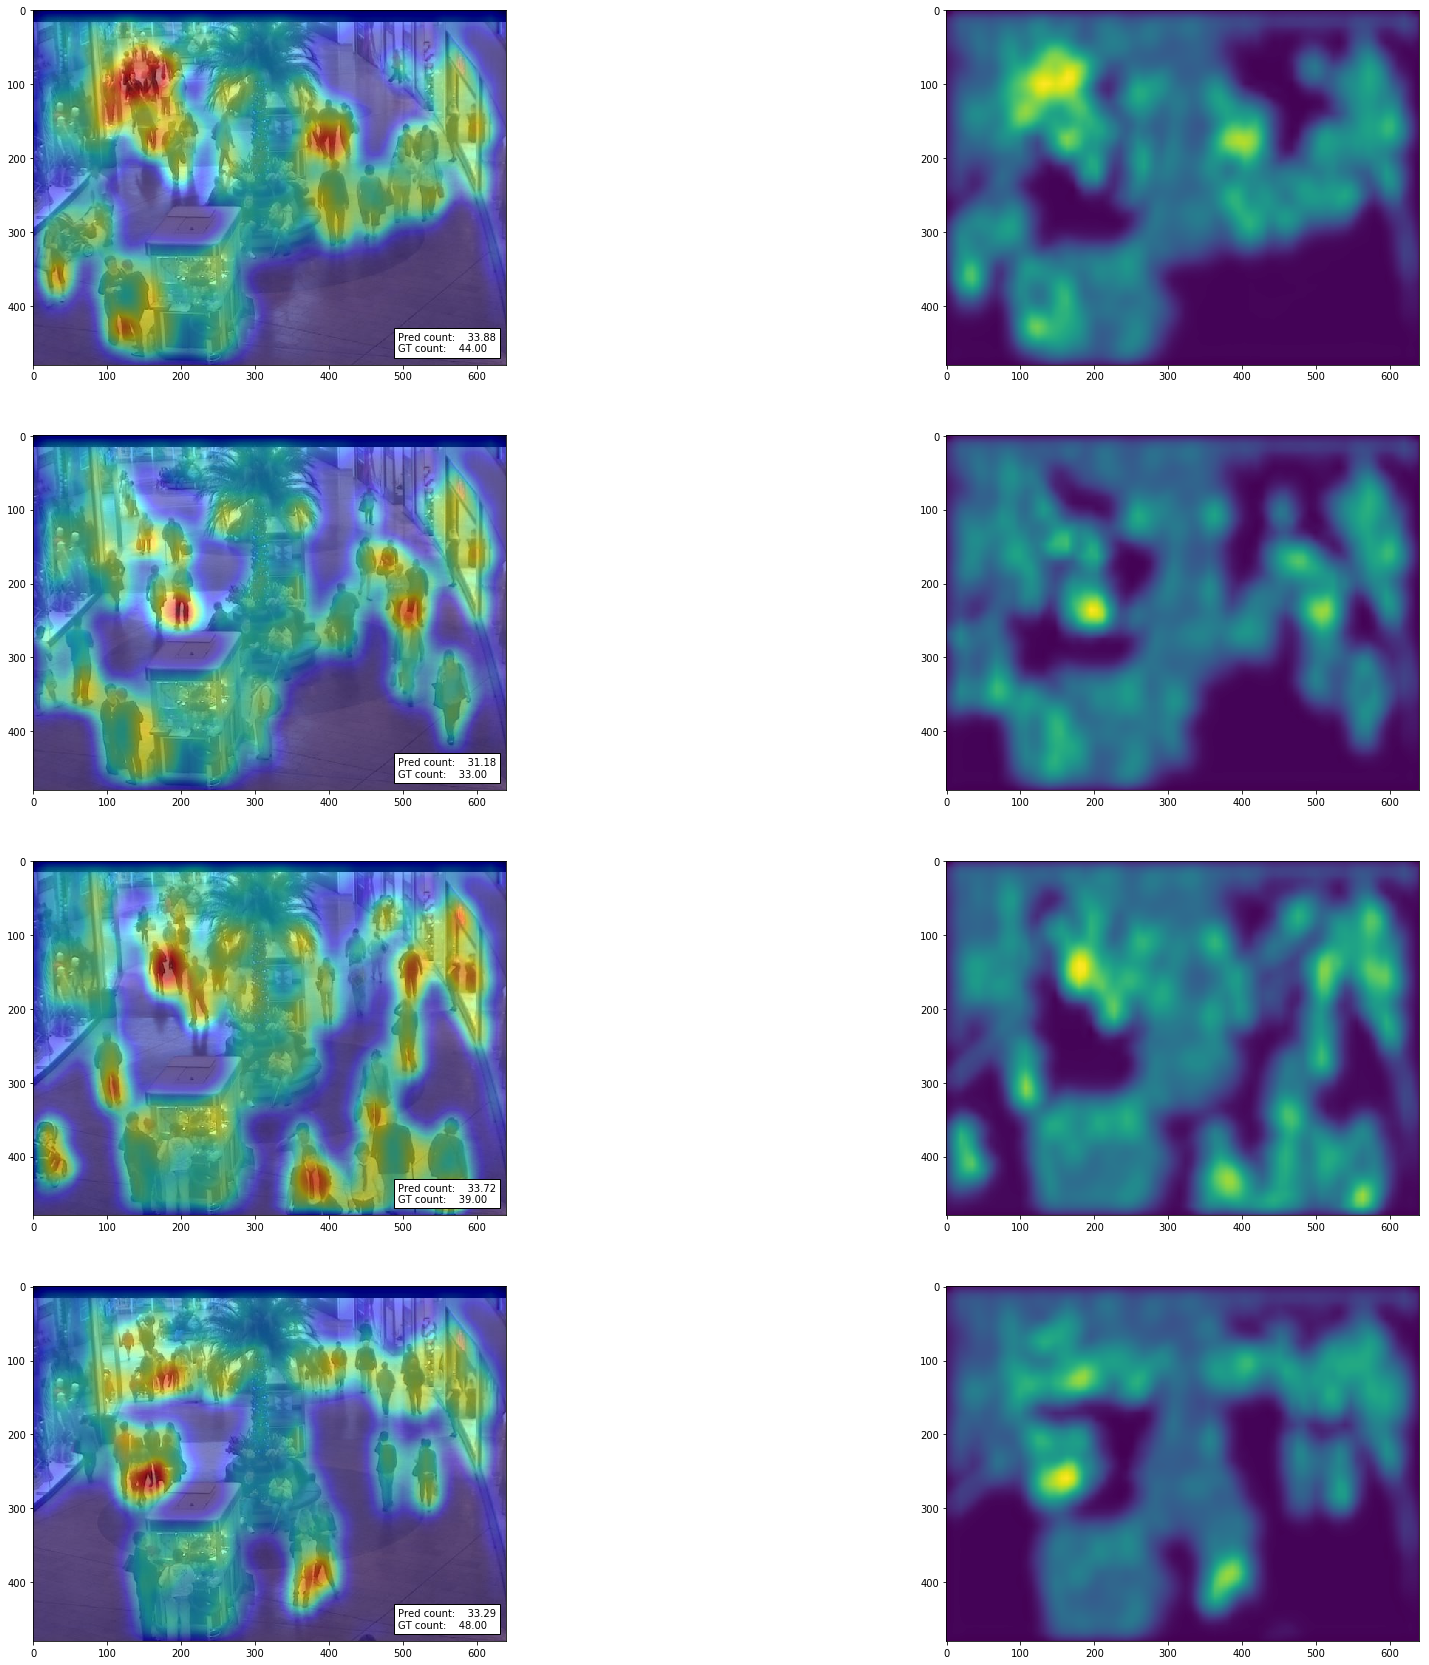

In [20]:
from matplotlib import cm
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
nrows, ncols = (4, 2)

#get random choice indexes from batch
choice = np.random.choice(input_test.shape[0], size=(nrows,), replace=False)
choice

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30, 30))
for i in range(nrows):
    idx, original_image, label__, count__ = mall_dset.__getitem__(idxs_test[choice[i]])
    output_map_resize = skimage.transform.resize(output_map_test[choice[i]].detach().numpy(), 
                               (480, 640), 
                               anti_aliasing=True)
    offsetbox = TextArea("Pred count: {0:8.2f}".format(output_count_test[choice[i]].item()) + 
                         "\nGT count: {0:8.2f}".format(float(count__)),
                         minimumdescent=False)
    ab = AnnotationBbox(offsetbox, (560,450), #(x, y)
                        xybox=(0, 0),
                        xycoords='data',
                        boxcoords="offset points")
    
    axes[i,0].imshow(original_image)
    axes[i,0].imshow(output_map_resize, cm.jet, alpha=0.5)
    axes[i,0].add_artist(ab)
    
    axes[i,1].imshow(output_map_resize)

### Packing it to function

In [18]:
import torch.nn.functional as F
import time


from matplotlib import cm
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
def save_pred(idxs, no_trans_loader, dens_map, pred_count, model_dir=None):

    for i, idx in enumerate(idxs):
        fig, axes = plt.subplots(figsize=(15, 15))
        (_, original_image, 
          label__, count__) = no_trans_loader.__getitem__(idx)
        
        original_size = (original_image.size[1], original_image.size[0])#reformat as H, W
        output_map_resize = skimage.transform.resize(dens_map[i], 
                                   (480, 640), 
                                   anti_aliasing=True)
        offsetbox = TextArea("Pred count: {0:8.2f}".format(pred_count[i].item()) + 
                             "\nGT count: {0:8.2f}".format(float(count__)),
                             minimumdescent=False)
        ab = AnnotationBbox(offsetbox, (560,450), #(x, y)
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points")

        axes.imshow(original_image)
        axes.imshow(output_map_resize, cm.jet, alpha=0.5)
        axes.add_artist(ab)
        
        file_name = os.path.join(model_dir, 'samples_{0}'.format(str(idx).zfill(6)))
        fig.savefig(file_name)
        plt.close(fig)
        
        
def test(model, test_loader, no_trans_dloader, device='cpu', model_dir=None):
    model = model.eval().to(device)
        
    criterion_count = nn.SmoothL1Loss()
    criterion_cam = nn.L1Loss()
    stats = {}
    (stats['losses'], stats['losses_count'], 
     stats['losses_cam'], stats['mse_countes'], 
     stats['mae_countes'], stats['overest_meter'], 
     stats['underest_meter'], stats['totalest_meter']) = [AverageMeter()]*8

    underest_epoch, overest_epoch, totalest_epoch, total_count = 0.0, 0.0, 0.0, 0.0;
    mae_epoch, mse_epoch = 0., 0.
    # switch to train mode
    model.train()

    time_start = time.time()
    n_samples = 0
    # (idxs, images, labels, counts)
    for i, (idxs, inputs, gams, targets) in enumerate(test_loader):
        tic = time.time()
        inputs = inputs.to(device)
        gams = gams.to(device).float()
        targets = targets.to(device).float()
        
        # compute output
        output_count, output_cam = model(inputs)
        output_count = output_count.view(-1)
        
        loss_count = F.smooth_l1_loss(output_count, targets)
        loss_cam = F.l1_loss(output_cam, gams)
        loss = loss_count + loss_cam
        
        mse_count = F.mse_loss(output_count, targets)
        mae_count = F.l1_loss(output_count, targets)
        overest, underest, totalest, batch_count = accuracy(output_count.data, 
                                                            targets)
        
        batch_size = inputs.size(0)
        stats['losses'].update(loss.item(), batch_size)
        stats['losses_count'].update(loss_count, batch_size)
        stats['losses_cam'].update(loss_cam, batch_size)
        stats['mse_countes'].update(mse_count, batch_size)
        stats['mae_countes'].update(mae_count, batch_size)
        stats['overest_meter'].update(overest, batch_size) 
        stats['underest_meter'].update(underest, batch_size)
        stats['totalest_meter'].update(totalest, batch_size)
        
        if i%1 == 0:
            toc = time.time()
            print("Batch {0}".format(i))
            print("time:", toc-tic)
            stats_str = ""
            for k, v in stats.items():
                stats_str += ("{0}:{1:.4f}\t".format(k, v.avg))
            print(stats_str)
            
        save_pred(idxs.detach().cpu().numpy(), no_trans_dloader, 
          output_cam.detach().cpu().numpy(), 
          output_count.detach().cpu().numpy(), model_dir=model_dir)
            
    return {k:v.avg for k, v in stats.items()}

In [ ]:
test(model, test_loader, mall_dset, model_dir=os.path.join(model_dir, 'test_samples'), device='cpu')

Batch 0
time: 1.5582528114318848
losses:44.0607	losses_count:44.0607	losses_cam:44.0607	mse_countes:44.0607	mae_countes:44.0607	overest_meter:44.0607	underest_meter:44.0607	totalest_meter:44.0607	
Batch 1
time: 1.560546875
losses:87.2523	losses_count:87.2523	losses_cam:87.2523	mse_countes:87.2523	mae_countes:87.2523	overest_meter:87.2523	underest_meter:87.2523	totalest_meter:87.2523	
Batch 2
time: 1.5398857593536377
losses:114.5628	losses_count:114.5628	losses_cam:114.5628	mse_countes:114.5628	mae_countes:114.5628	overest_meter:114.5628	underest_meter:114.5628	totalest_meter:114.5628	
Batch 3
time: 1.5203592777252197
losses:112.2648	losses_count:112.2648	losses_cam:112.2648	mse_countes:112.2648	mae_countes:112.2648	overest_meter:112.2648	underest_meter:112.2648	totalest_meter:112.2648	
Batch 4
time: 1.4652585983276367
losses:100.1542	losses_count:100.1542	losses_cam:100.1542	mse_countes:100.1542	mae_countes:100.1542	overest_meter:100.1542	underest_meter:100.1542	totalest_meter:100.1542